# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras

## 70. 単語ベクトルの和による特徴量

### データ準備

In [2]:
# 学習データ，検証データ，評価データ読み込み
df_train = pd.read_csv('train.txt', sep='\t')
df_valid = pd.read_csv('valid.txt', sep='\t')
df_test = pd.read_csv('test.txt', sep='\t')
df_test.head()

,CATEGORY,TITLE
0,b,Vodafone's Service Revenue Falls as European M...
1,e,"So, Tupac Shakur's Final Words Were A Big ""F*C..."
2,t,Elephants really are intelligent: Creatures ca...
3,t,FTC says Snapchat deceived customers over 'dis...
4,b,UPDATE 3-GM says facing multiple probes into r...


### ラベルベクトル作成

In [5]:
def trans_label_int(label: str) -> int:
    if label == 'b':
        return 0
    elif label == 't':
        return 1
    elif label == 'e':
        return 2
    elif label == 'm':
        return 3

print(trans_label_int(label='b'))
print(trans_label_int(label='t'))
print(trans_label_int(label='e'))
print(trans_label_int(label='m'))

0
1
2
3


In [11]:
# ラベルを整数に変換
y_train = (
    df_train
    .loc[:, 'CATEGORY']
    .apply(trans_label_int)
    .values
)
y_valid = (
    df_valid
    .loc[:, 'CATEGORY']
    .apply(trans_label_int)
    .values
)
y_test = (
    df_test
    .loc[:, 'CATEGORY']
    .apply(trans_label_int)
    .values
)

In [13]:
np.save('70_y_train.npy', y_train)
np.save('70_y_valid.npy', y_valid)
np.save('70_y_test.npy', y_test)

### 特徴量行列作成

#### 単語の出現回数取得

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# 試しに動かす
vectorizer = CountVectorizer()

tes = pd.DataFrame([
    'This is my car',
    'This is my friend',
    'This is my English book',
], columns=['TITLE'])

tes_vector = vectorizer.fit_transform(tes['TITLE'].tolist())

print(vectorizer.get_feature_names())
print(tes_vector.toarray())

['book', 'car', 'english', 'friend', 'is', 'my', 'this']
[[0 1 0 0 1 1 1]
 [0 0 0 1 1 1 1]
 [1 0 1 0 1 1 1]]


In [5]:
vectorizer = CountVectorizer()
# 計算 & 変換
train_data = vectorizer.fit_transform(df_train['TITLE'].tolist()).toarray()
feature_names = vectorizer.get_feature_names()
# 変換
valid_data = vectorizer.transform(df_valid['TITLE'].tolist()).toarray()
test_data = vectorizer.transform(df_test['TITLE'].tolist()).toarray()

In [19]:
type(feature_names)

list

In [31]:
def trans_title_word_cnt(array: np.ndarray, columns: list) -> pd.DataFrame:
    """
    入力
    array: 単語の出現回数
    columns: 単語リスト
    出力
    データフレーム
    - Title No
    - 単語
    - 出現回数
    """
    df = (
        pd.DataFrame(array, columns=columns)
        .applymap(lambda x: np.nan if x == 0 else x)
        .stack()
        .reset_index()
    )
    df.columns = ['No', 'word', 'cnt']
    return df

tes_array = np.array([[0, 1, 2], [3, 4, 5]])
tes_columns = ['a', 'b', 'c']
trans_title_word_cnt(array=tes_array, columns=tes_columns)

,No,word,cnt
0,0,b,1.0
1,0,c,2.0
2,1,a,3.0
3,1,b,4.0
4,1,c,5.0


In [32]:
# 縦持ちのDataFrame
df_train_word_count = trans_title_word_cnt(array=train_data, columns=feature_names)
df_valid_word_count = trans_title_word_cnt(array=valid_data, columns=feature_names)
df_test_word_count = trans_title_word_cnt(array=test_data, columns=feature_names)

In [33]:
df_train_word_count.head()

,No,word,cnt
0,0,abs,1.0
1,0,auto,1.0
2,0,consumer,1.0
3,0,criteria,1.0
4,0,emea,1.0


#### タイトルごとの単語ベクトル平均値算出

In [34]:
from gensim.models import KeyedVectors

In [35]:
# 学習済み単語ベクトル
vector_path = os.path.join(os.getcwd(), '../data/GoogleNews-vectors-negative300.bin')

In [36]:
# 読み込み
wv_from_bin = KeyedVectors.load_word2vec_format(vector_path, binary=True)

In [107]:
# word列の単語ベクトルを返す
def get_word_vector(row, vector) -> pd.DataFrame:
    try:
        return vector[row['word']] * row['cnt']
    except KeyError:
        ret_len = len(vector['an']) # 適当な単語で長さ取得
        return np.zeros(ret_len)

(
    pd.DataFrame(
        [
            [1, 'shakur', 1.0],
            [0, 'abs', 1.0],
            [0, 'auto', 1.0],
            [1, 'auto', 2.0],
        ],
        columns=['No', 'word', 'cnt']
    )
    .apply(get_word_vector, axis=1, result_type='expand', vector=wv_from_bin)
)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.108887,0.029907,0.373047,0.371094,-0.038818,0.283203,-0.051025,-0.141602,-0.229492,0.097168,...,0.018677,-0.166992,-0.267578,-0.345703,0.322266,-0.024048,0.074219,0.072754,-0.308594,-0.190430
2,0.166992,0.201172,0.086914,0.189453,-0.137695,0.206055,0.042236,0.081543,0.126953,-0.037598,...,-0.310547,-0.038086,0.188477,-0.100586,-0.038330,0.149414,-0.176758,0.353516,-0.000847,-0.357422
3,0.333984,0.402344,0.173828,0.378906,-0.275391,0.412109,0.084473,0.163086,0.253906,-0.075195,...,-0.621094,-0.076172,0.376953,-0.201172,-0.076660,0.298828,-0.353516,0.707031,-0.001694,-0.714844


In [108]:
def concat_df_wordvector(df: pd.DataFrame, vector) -> pd.DataFrame:
    return pd.concat(
        [
            df,
            df.apply(
                get_word_vector,
                axis=1,
                result_type='expand',
                vector=wv_from_bin
            )
        ],
        axis=1
    )

tes_df = (
    pd.DataFrame(
        [
            [1, 'shakur', 1.0],
            [0, 'abs', 1.0],
            [0, 'auto', 1.0],
            [1, 'auto', 2.0],
        ],
        columns=['No', 'word', 'cnt']
    )
)
concat_df_wordvector(df=tes_df, vector=wv_from_bin)

,No,word,cnt,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,1,shakur,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,abs,1.0,0.108887,0.029907,0.373047,0.371094,-0.038818,0.283203,-0.051025,...,0.018677,-0.166992,-0.267578,-0.345703,0.322266,-0.024048,0.074219,0.072754,-0.308594,-0.190430
2,0,auto,1.0,0.166992,0.201172,0.086914,0.189453,-0.137695,0.206055,0.042236,...,-0.310547,-0.038086,0.188477,-0.100586,-0.038330,0.149414,-0.176758,0.353516,-0.000847,-0.357422
3,1,auto,2.0,0.333984,0.402344,0.173828,0.378906,-0.275391,0.412109,0.084473,...,-0.621094,-0.076172,0.376953,-0.201172,-0.076660,0.298828,-0.353516,0.707031,-0.001694,-0.714844


In [109]:
# 縦持ちデータフレームから、
def calculate_titile_wordvector(df: pd.DataFrame, vector) -> pd.DataFrame:
    return (
        concat_df_wordvector(df=df, vector=wv_from_bin)
        .drop(['word', 'cnt'], axis=1)
        .groupby('No')
        .mean()
    )

tes_df = (
    pd.DataFrame(
        [
            [0, 'abs', 1.0],
            [0, 'auto', 1.0],
            [1, 'auto', 2.0],
            [1, 'shakur', 1.0]
        ],
        columns=['No', 'word', 'cnt']
    )
)

calculate_titile_wordvector(df=tes_df, vector=wv_from_bin)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
No,,,,,,,,,,,,,,,,,,,,,
0,0.137939,0.115540,0.229980,0.280273,-0.088257,0.244629,-0.004395,-0.030029,-0.051270,0.029785,...,-0.145935,-0.102539,-0.039551,-0.223145,0.141968,0.062683,-0.051270,0.213135,-0.154720,-0.273926
1,0.166992,0.201172,0.086914,0.189453,-0.137695,0.206055,0.042236,0.081543,0.126953,-0.037598,...,-0.310547,-0.038086,0.188477,-0.100586,-0.038330,0.149414,-0.176758,0.353516,-0.000847,-0.357422


In [111]:
# titleごとの平均単語ベクトル
df_train_features = calculate_titile_wordvector(df=df_train_word_count, vector=wv_from_bin)
df_valid_features = calculate_titile_wordvector(df=df_valid_word_count, vector=wv_from_bin)
df_test_features = calculate_titile_wordvector(df=df_test_word_count, vector=wv_from_bin)

In [115]:
np.save('70_x_train.npy', df_train_features.values)
np.save('70_x_valid.npy', df_valid_features.values)
np.save('70_x_test.npy', df_test_features.values)

## 71. 単層ニューラルネットワークによる予測

In [3]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [4]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(300,)),
  tf.keras.layers.Dense(4)
])

In [6]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(300, 4) dtype=float32, numpy=
 array([[-0.02405263,  0.05797277,  0.08333877, -0.11684883],
        [-0.04438991,  0.0755439 ,  0.12357919, -0.07688701],
        [ 0.03131263, -0.00477631, -0.05933721, -0.03981956],
        ...,
        [-0.04004994, -0.05251788,  0.01854898,  0.13610975],
        [-0.10553957,  0.12458913, -0.06835857,  0.03758542],
        [ 0.06262796,  0.09886761,  0.10989659, -0.04294457]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [7]:
y_pred_1 = model(x_train[:1])
y_pred_1

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01577283,  0.17237882,  0.09412156, -0.11099218]],
      dtype=float32)>

In [8]:
y_tilde_1 = tf.nn.softmax(y_pred_1)
y_tilde_1

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.23627536, 0.28518826, 0.26372114, 0.21481529]], dtype=float32)>

In [9]:
Y_pred = model(x_train[:4])
Y_pred

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-0.01577287,  0.17237884,  0.09412153, -0.11099222],
       [ 0.01490638,  0.0766397 ,  0.06239213,  0.0344914 ],
       [-0.11694963,  0.15236321,  0.10474639, -0.0472367 ],
       [-0.00807093,  0.2212768 ,  0.10077907,  0.04352715]],
      dtype=float32)>

In [10]:
Y_tilde = tf.nn.softmax(Y_pred)
Y_tilde

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.23627533, 0.28518826, 0.26372114, 0.21481527],
       [0.2420084 , 0.25741917, 0.25377756, 0.24679486],
       [0.21600804, 0.2827685 , 0.2696195 , 0.2316039 ],
       [0.22595158, 0.2841972 , 0.2519349 , 0.23791625]], dtype=float32)>

## 72. 損失と勾配の計算

### クロスエントロピー損失

In [11]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
loss_fn(y_train[:1], y_tilde_1).numpy()

1.4003756

In [13]:
loss_fn(y_train[:4], Y_tilde).numpy()

1.3970408

### 行列Wに対する勾配

In [14]:
x = tf.Variable(x_train[:1])
with tf.GradientTape() as tape:
    y = tf.nn.softmax(model(x))

In [15]:
tape.gradient(y, x)

<tf.Tensor: shape=(1, 300), dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [16]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [17]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
334/334 [==============================] - 0s 541us/step - loss: 1.2848 - accuracy: 0.4676
Epoch 2/100
334/334 [==============================] - 0s 514us/step - loss: 1.0871 - accuracy: 0.7224
Epoch 3/100
334/334 [==============================] - 0s 502us/step - loss: 1.0114 - accuracy: 0.7528
Epoch 4/100
334/334 [==============================] - 0s 489us/step - loss: 0.9702 - accuracy: 0.7485
Epoch 5/100
334/334 [==============================] - 0s 514us/step - loss: 0.9191 - accuracy: 0.7626
Epoch 6/100
334/334 [==============================] - 0s 495us/step - loss: 0.8933 - accuracy: 0.7636
Epoch 7/100
334/334 [==============================] - 0s 501us/step - loss: 0.8695 - accuracy: 0.7617
Epoch 8/100
334/334 [==============================] - 0s 477us/step - loss: 0.8407 - accuracy: 0.7644
Epoch 9/100
334/334 [==============================] - 0s 486us/step - loss: 0.8131 - accuracy: 0.7712
Epoch 10/100
334/334 [==============================] - 0s 514us/step - l

## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [18]:
# 学習データの正解率
model.evaluate(x_train, y_train, verbose=2)

334/334 - 0s - loss: 0.4534 - accuracy: 0.8520


[0.4533558189868927, 0.8520427346229553]

In [19]:
# 評価データの正解率
model.evaluate(x_test, y_test, verbose=2)

42/42 - 0s - loss: 0.4569 - accuracy: 0.8561


[0.4569278061389923, 0.856071949005127]

## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [20]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
334/334 [==============================] - 1s 2ms/step - loss: 0.4529 - accuracy: 0.8522 - val_loss: 0.4577 - val_accuracy: 0.8531
Epoch 2/100
334/334 [==============================] - 0s 616us/step - loss: 0.4519 - accuracy: 0.8530 - val_loss: 0.4567 - val_accuracy: 0.8531
Epoch 3/100
334/334 [==============================] - 0s 631us/step - loss: 0.4509 - accuracy: 0.8533 - val_loss: 0.4557 - val_accuracy: 0.8538
Epoch 4/100
334/334 [==============================] - 0s 643us/step - loss: 0.4499 - accuracy: 0.8539 - val_loss: 0.4548 - val_accuracy: 0.8546
Epoch 5/100
334/334 [==============================] - 0s 626us/step - loss: 0.4489 - accuracy: 0.8540 - val_loss: 0.4538 - val_accuracy: 0.8546
Epoch 6/100
334/334 [==============================] - 0s 646us/step - loss: 0.4479 - accuracy: 0.8543 - val_loss: 0.4529 - val_accuracy: 0.8561
Epoch 7/100
334/334 [==============================] - 0s 643us/step - loss: 0.4469 - accuracy: 0.8549 - val_loss: 0.4520 - val_accu

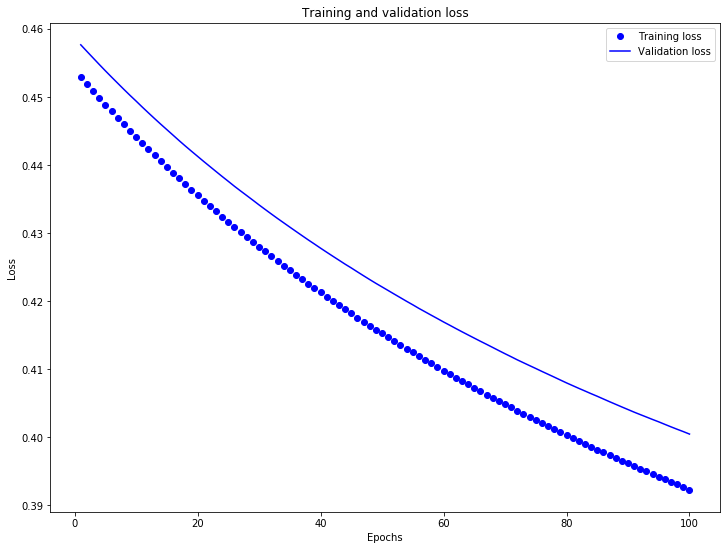

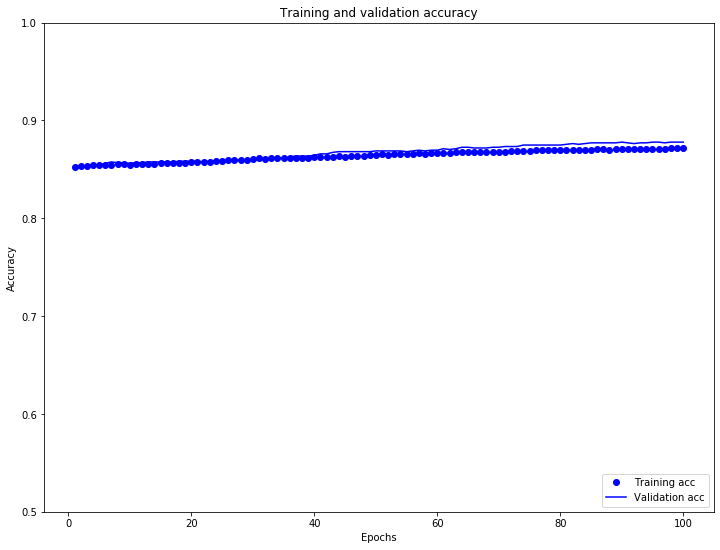

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．